In [1]:
import pandas as pd
import numpy as np
from helper import *

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

As the first step I used the feature summary file (DIAS Attributes - Values 2017.xlsx) to understand the data, mainly:

- what kind of information is provided in the dataset 
- how the values assigned to each attributes
- data types of the features/attributes 
- missing values encoding

In [2]:
df_features = pd.read_excel(
    'DIAS Attributes - Values 2017.xlsx', header=[1], usecols=[1, 3, 4], index_col=[0, 1])
df_features = df_features.reset_index()

In [3]:
df_features.head(5)

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,AGER_TYP,0,no classification possible
2,AGER_TYP,1,passive elderly
3,AGER_TYP,2,cultural elderly
4,AGER_TYP,3,experience-driven elderly


In [4]:
# "CAMEO_INTL_2015" in df_features.Attribute

In [5]:
dtype={'CAMEO_DEUG_2015': 'object', 'CAMEO_INTL_2015': 'object'}
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv',
                     sep=';', dtype = dtype, nrows=5000 )
del azdias['LNR'] 

attributes = list(set(np.concatenate([df_features.Attribute.unique(), azdias.columns])))


In [6]:
fea_ = np.setdiff1d(azdias.columns, df_features.Attribute.unique())
print('{:} features not explained in feature summary file:'.format(len(fea_)))
# print(fea_)

93 features not explained in feature summary file:


In [7]:
fea__ = np.setdiff1d( df_features.Attribute.unique(), azdias.columns)
print('{:} features not in azdias file:'.format(len(fea__)))
# print(fea__)

42 features not in azdias file:


From the comparison above, is noticed that there are 93 features not explained in the metadata file. We will need to figure out ourslves how these features are desribed in the general population dataset.

In [8]:
# remove the ones not used in azdias file 
attributes = list(set(attributes) - set(fea__))

In [9]:
customers = pd.read_csv(
    './data/Udacity_CUSTOMERS_052018.csv', sep=';',  dtype= dtype)
print('features in the customer, but not in the attribute list: {:}'.format(np.setdiff1d(customers.columns, attributes)))

mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype = dtype)
np.setdiff1d(mailout_train.columns, attributes)
print('features in the mailout, but not in the combined attribute list: {:}'.format(np.setdiff1d(mailout_train.columns, attributes)))


features in the customer, but not in the attribute list: ['CUSTOMER_GROUP' 'LNR' 'ONLINE_PURCHASE' 'PRODUCT_GROUP']
features in the mailout, but not in the combined attribute list: ['LNR' 'RESPONSE']


In [10]:
compare_dataframe_columns(df1 = customers, df2 = mailout_train, df1_name='customer', df2_name='mailout_train')

columns in df1 (customer) not in df2 (mailout_train)
['CUSTOMER_GROUP' 'ONLINE_PURCHASE' 'PRODUCT_GROUP']
columns in df2 (mailout_train) not in df1 (customer)
['RESPONSE']


In [11]:
# Determine if the mailout_train is a subset of the customer
df1 = customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']).copy()
df2 = mailout_train.drop(columns=['RESPONSE']).copy()

df = pd.concat([df1, df2])
df.duplicated().sum()

227

In [12]:
## Summary section
print('total number of features: {:}'.format(len(attributes))) 
print("total number of features in azdias: {:}".format(np.shape(azdias)[1]))
print("total number of features in customers: {:}".format(np.shape(customers)[1]))
print("total number of features in training data: {:}".format(np.shape(mailout_train)[1]))

total number of features: 365
total number of features in azdias: 365
total number of features in customers: 369
total number of features in training data: 367


## feature summary 

In this section, I will utilize information contained in 'DIAS Attributes - Values 2017.xlsx' to provide a summary on attributes values. 

A quick scan show that data in file is mostly ordinal. For example,"D19_BANKEN_ANZ_12" describes the frequency of transaction activity of the client. the values range from least frequent (0 = very low activity) to the most frequent (6 = very high activity). Since the values used to describe the feature is ranking based, i will treat it as ordinal. As most of features are ordinal, i will pre-assign feature type as 'ordinal'. If further analysis shows otherwise, I will update it  at a later time.


In [13]:
df_features[df_features["Attribute"] == 'D19_BANKEN_ANZ_12']

,Attribute,Value,Meaning
138,D19_BANKEN_ANZ_12,0,no transactions known
139,D19_BANKEN_ANZ_12,1,very low activity
140,D19_BANKEN_ANZ_12,2,low activity
141,D19_BANKEN_ANZ_12,3,slightly increased activity
142,D19_BANKEN_ANZ_12,4,increased activity
143,D19_BANKEN_ANZ_12,5,high activity
144,D19_BANKEN_ANZ_12,6,very high activity


In [14]:
# crate a dataframe for feature summary
df_feat_summary = pd.DataFrame()
df_feat_summary['Attribute'] = attributes
df_feat_summary['type'] = 'ordinal' 

# create an empty list to contain cat/num features that need to be ajusted in the summary df
cat_features = []
num_features = []

In [15]:
df_feat_summary['Attribute'].head()

0    KBA13_KMH_140_210
1        CJT_GESAMTTYP
2     FINANZ_VORSORGER
3           D19_GARTEN
4           KBA05_CCM2
Name: Attribute, dtype: object

Names of attributes in 'DIAS Attributes - Values 2017.xlsx' mostly compose of several parts. 

For example,  "D19_NAHRUNGSERGAENZUNG_RZ", the first part "D19" presents data source and the rest describe the attributes (NAHRUNGSERGAENZUN = FOOD SUPPLEMENT). As data from the same source tend to be encoded in a similar manner, i decided to split the attribute names and use the firt part (prefix) to investigate feature encoding in groups. 

### split attribute names

In [16]:
df_features['attribute_prefix'] = df_features.Attribute.apply(attribute_group)

In [17]:
# Count the sources of features, or the types of features.
top_count_features = df_features.Attribute.drop_duplicates().apply(attribute_group).value_counts().head(10)

In [18]:
top_count_features

KBA13          108
KBA05           65
D19             61
SEMIO           14
PLZ8             7
FINANZ           6
LP               6
ANZ              4
CAMEO            3
GEBAEUDETYP      2
Name: Attribute, dtype: int64

In [19]:
feat_counts = df_features.Attribute.drop_duplicates().count()
print('features count, total: {:}'.format(feat_counts))

feat_anlyzed = top_count_features.sum()
print('features count with a specified pre-fix: {:}'.format(feat_anlyzed))

print('features count without a specified pre-fix: {:}'.format(feat_counts - feat_anlyzed))

features count, total: 314
features count with a specified pre-fix: 276
features count without a specified pre-fix: 38


#### D19

In [20]:
# D19 provides informat about trasaction activities, cat data
# columns kept: D19_KONSUMTYP
d19_attribute_meanings = attribute_meanings(df_features,'D19')

['no transactions known' 'very low activity' 'low activity'
 'slightly increased activity' 'increased activity' 'high activity'
 'very high activity' 'highest activity within the last 12 months'
 'very high activity within the last 12 months'
 'high activity within the last 12 months'
 'increased activity within the last 12 months'
 'slightly increased activity within the last 12 months'
 'activity elder than 1 year' 'activity elder than 1,5 years'
 'activity elder than 2 years' 'activity elder than 3 years'
 'no transaction known' 'Multibuyer 0-12 months' 'Doublebuyer 0-12 months'
 'Singlebuyer 0-12 months' 'Multi-/Doublebuyer 13-24 months'
 'Singlebuyer 13-24 months' 'Buyer > 24 months' 'Prospects > 24 months'
 'activity elder than 12 months' 'activity elder than 18 months'
 'activity elder than 24 months' 'activity elder than 36 months'
 'no Online-transactions within the last 12 months'
 '10% Online-transactions within the last 12 months'
 '20% Online-transactions within the last 1

D19 data describes the trascation activity. All features, except for "D19_KONSUMTYP" are ornidal data. "D19_KONSUMTYP" is catgorical, therefore it will be appended to the cat feature list. Missing vlaues or unknows are descrbied either as "no transactions known", or "no transaction known", or 'unknown', or unspecified in the information file. 

In [21]:
cat_features.extend(['D19_KONSUMTYP'])

#### KBA05

In [22]:
# Family and cars, ordnial information, ordinal data
kba_05_meanings  = attribute_meanings(df_features, 'KBA05') 

['unknown' 'none' 'low' 'average' 'high' 'very high' 'very low' 'some'
 'some more' 'very many' 'no 1-2 family homes'
 'lower share of 1-2 family homes' 'average share of 1-2 family homes'
 'high share of 1-2 family homes' 'very high share of 1-2 family homes'
 'no 3-5 family homes' 'lower share of 3-5 family homes'
 'average share of 3-5 family homes' 'high share of 3-5 family homes'
 'very high share of 3-5 family homes' 'no 6-10 family homes'
 'lower share of 6-10 family homes' 'average share of 6-10 family homes'
 'high share of 6-10 family homes' 'no >10 family homes'
 'lower share of >10 family homes' 'high share of >10 family homes'
 'very low car quote' 'low car quote' 'average car quote' 'high car quote'
 'very high car quote' 'mainly 1-2 family homes in the microcell'
 'mainly 3-5 family homes in the microcell'
 'mainly 6-10 family homes in the microcell'
 'mainly>10 family homes in the microcell'
 'mainly business buildings in the microcell' '1-2 buildings'
 '3-4 buildings' 

KBA05 data describes house and car the person owns.

In [23]:
for att in ["KBA05_BAUMAX", "KBA05_HERSTTEMP", \
            "KBA05_MAXHERST","KBA05_MAXSEG", "KBA05_MAXVORB", "KBA05_MOTOR"]:
    display(df_features[df_features.Attribute == att])

,Attribute,Value,Meaning,attribute_prefix
822,KBA05_BAUMAX,"-1, 0",unknown,KBA05
823,KBA05_BAUMAX,1,mainly 1-2 family homes in the microcell,KBA05
824,KBA05_BAUMAX,2,mainly 3-5 family homes in the microcell,KBA05
825,KBA05_BAUMAX,3,mainly 6-10 family homes in the microcell,KBA05
826,KBA05_BAUMAX,4,mainly>10 family homes in the microcell,KBA05
827,KBA05_BAUMAX,5,mainly business buildings in the microcell,KBA05


,Attribute,Value,Meaning,attribute_prefix
905,KBA05_HERSTTEMP,"-1, 9",unknown,KBA05
906,KBA05_HERSTTEMP,1,promoted,KBA05
907,KBA05_HERSTTEMP,2,stayed upper level,KBA05
908,KBA05_HERSTTEMP,3,stayed lower/average level,KBA05
909,KBA05_HERSTTEMP,4,demoted,KBA05
910,KBA05_HERSTTEMP,5,new building,KBA05


,Attribute,Value,Meaning,attribute_prefix
980,KBA05_MAXHERST,"-1, 9",unknown,KBA05
981,KBA05_MAXHERST,1,Top-German,KBA05
982,KBA05_MAXHERST,2,VW-Audi,KBA05
983,KBA05_MAXHERST,3,Ford/Opel,KBA05
984,KBA05_MAXHERST,4,European,KBA05
985,KBA05_MAXHERST,5,Asian,KBA05


,Attribute,Value,Meaning,attribute_prefix
986,KBA05_MAXSEG,"-1, 9",unknown,KBA05
987,KBA05_MAXSEG,1,small car,KBA05
988,KBA05_MAXSEG,2,lower middleclass car,KBA05
989,KBA05_MAXSEG,3,middle class car,KBA05
990,KBA05_MAXSEG,4,upper class car,KBA05


,Attribute,Value,Meaning,attribute_prefix
991,KBA05_MAXVORB,"-1, 9",unknown,KBA05
992,KBA05_MAXVORB,1,no preowner,KBA05
993,KBA05_MAXVORB,2,1 preowner,KBA05
994,KBA05_MAXVORB,3,2 or more preowner,KBA05


,Attribute,Value,Meaning,attribute_prefix
1031,KBA05_MOTOR,"-1, 9",unknown,KBA05
1032,KBA05_MOTOR,1,very small engine,KBA05
1033,KBA05_MOTOR,2,small engine,KBA05
1034,KBA05_MOTOR,3,average engine,KBA05
1035,KBA05_MOTOR,4,big engine,KBA05


In [24]:
cat_features.extend(["KBA05_BAUMAX", "KBA05_HERSTTEMP", \
            "KBA05_MAXHERST","KBA05_MAXSEG", "KBA05_MAXVORB", "KBA05_MOTOR"])
print(cat_features)

['D19_KONSUMTYP', 'KBA05_BAUMAX', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOTOR']


#### KBA13

In [25]:
# get_features(df_features, 'KBA13')

In [26]:
# Familiy and cars of the neighbourhood, Ordinal information
kba_05_meanings  = attribute_meanings(df_features, 'KBA13')

['unknown' 'none' 'very low' 'low' 'average' 'high' 'very high'
 'numeric value' 'mainly small engines' 'mainly medium sized engines'
 'mainly high engines' 'mainly very big engines']


In [27]:
display(df_features[df_features.Attribute == "KBA13_MOTOR"])

,Attribute,Value,Meaning,attribute_prefix
1671,KBA13_MOTOR,-1,unknown,KBA13
1672,KBA13_MOTOR,0,none,KBA13
1673,KBA13_MOTOR,1,mainly small engines,KBA13
1674,KBA13_MOTOR,2,mainly medium sized engines,KBA13
1675,KBA13_MOTOR,3,mainly high engines,KBA13
1676,KBA13_MOTOR,4,mainly very big engines,KBA13


In [28]:
cat_features.extend(["KBA13_MOTOR"])

#### LP 

In [29]:
# Describes the family status of each person, categorical, to reduce the dimensions: keep only '_GROB'
lp_meanings  = attribute_meanings(df_features, 'LP')

['single ' 'couple' 'young single parent ' 'single parent with teenager'
 'single parent with child of full age' 'young family '
 'family with teenager ' 'family with child of full age' 'shared flat'
 'two-generational household' 'multi-generational household'
 'single parent' nan 'family' 'multiperson household'
 'single low-income earners of younger age'
 'single low-income earners of middle age'
 'single average earners of younger age '
 'single average earners of middle age'
 'single low-income earners of advanced age'
 'single low-income earners at retirement age '
 'single average earners of advanced age'
 'single average earners at retirement age' 'single independant persons'
 'wealthy single homeowners' 'single homeowners of advanced age'
 'single homeowners at retirement age' 'single top earners of higher age '
 'low-income- and average earner-couples of younger age'
 'low-income earner-couples of higher age'
 'average earner-couples of higher age ' 'independant couples'
 'wea

all the data is nominal, and provided in both 'fein' (fine) and 'groub' (rough). 

In [30]:
def get_features(df_features, prefix):
    """Get all attributes with the same prefix
    """
    feats = df_features.loc[df_features['attribute_prefix'] == prefix, 'Attribute'].unique()
    return feats

In [31]:
get_features(df_features, 'LP')

array(['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB'],
      dtype=object)

In [32]:
cat_features.extend( get_features(df_features, 'LP'))
# print(cat_features)

#### FINANZ

Features that contains 'FINANZ' in the names, describes the financial typology a savor or an investor). All the features, except for "FINANZTYP" (TYP- type) will be treated as ordinal data with 'unknown' encoded as [-1]. FINANZTYP best describes the financial type for the person. it will be treated as catogrical, with unkonwn treated as [-1].

In [33]:
# Describes the financial typology 
# mostly ordinal, except: FINANZTYP
# Unknown is encoded as 'unknown'
df_features.loc[df_features.Attribute.str.contains('FINANZ'), "Meaning"].unique()

array(['unknown', 'low finacial interest', 'money saver',
       'main focus is the own house', 'be prepared', 'Investor',
       'unremarkable', 'very high', 'high', 'average', 'low', 'very low'],
      dtype=object)

In [34]:
cat_features.extend(['FINANZTYP'])

#### ANZ

In [35]:
## ANZ: all are numerical vlaues 
df_features[df_features['attribute_prefix'] == 'ANZ']

,Attribute,Value,Meaning,attribute_prefix
36,ANZ_HAUSHALTE_AKTIV,…,numeric value (typically coded from 1-10),ANZ
37,ANZ_HH_TITEL,…,numeric value (typically coded from 1-10),ANZ
38,ANZ_PERSONEN,…,numeric value (typically coded from 1-3),ANZ
39,ANZ_TITEL,…,numeric value (typically coded from 1-10),ANZ


In [36]:
num_features.extend(get_features(df_features, 'ANZ'))

# print(list(set(num_features)))

#### CAMEO Features

In [37]:
## CAMEO: all are numerical vlaues 
df_features.loc[df_features['attribute_prefix'] == 'CAMEO', 'Meaning'].unique()

array(['unknown', 'upper class', 'upper middleclass',
       'established middleclasse', 'consumption-oriented middleclass ',
       'active middleclass ', 'low-consumption middleclass',
       'lower middleclass', 'working class', 'urban working class',
       'Work-Life-Balance', 'Wealthy Best Ager', 'Successful Songwriter',
       'Old Nobility', 'City Nobility', 'Cottage Chic', 'Noble Jogger',
       'Established gourmet', 'Fine Management', 'Career & Family',
       'Powershopping Families', 'Rural Neighborhood',
       'Secure Retirement', 'Family Starter', 'Family Life',
       'String Trimmer', 'Empty Nest', 'Golden Ager', 'Younger Employees',
       'Suddenly Family', 'Family First', 'Stock Market Junkies',
       'Coffee Rider', 'Active Retirement', 'Jobstarter',
       'Petty Bourgeois', 'Long-established', 'Sportgardener',
       'Urban Parents', 'Frugal Aging', 'Journeymen', 'Mantaplatte',
       'Factory Worker', 'Rear Window', 'Interested Retirees',
       'Multi-cultera

In [38]:
cat_mixed = ['CAMEO_DEUG_2015', 'CAMEO_DEUINTL_2015'] 

In [39]:
get_features(df_features, prefix='CAMEO')

array(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015'],
      dtype=object)

In [40]:
cat_features.extend(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', "CAMEO_INTL_2015"])

- 'CAMEO_DEU_2015' includes 44 categories in total, requires further analyssi to decide how to treat it
- 'CAMEO_DEUINTL_2015' provides information about the housing and family status. therefore it is decided to split the data into two, one for housing and the other for family statu

#### GEBAEUDETYP 

In [41]:
GEBAEUDETYP_feats = get_features(df_features, prefix='GEBAEUDETYP')

In [42]:
# GEBAEUDETYP_feats

In [43]:
# cat gorical data, keep both
df_features.loc[df_features['attribute_prefix'] == 'GEBAEUDETYP', 'Meaning'].unique()

array(['unknown', 'residental building',
       'residental building buildings without actually known household',
       'mixed (=residential and company) building ',
       'mixed building without actually known household or comapny ',
       'company building w/o known company ',
       'mixed building without actually known household ',
       'company building',
       'mixed building without actually known company ', 'business cell',
       'mixed cell with high business share',
       'mixed cell with middle business share',
       'mixed cell with low business share', 'residential cell'],
      dtype=object)

In [44]:
cat_features.extend(['GEBAEUDETYP', 'GEBAEUDETYP_RASTER'])

### Other features

In [45]:
search_for = '|'.join(top_count_features.index.values)
feat_to_analyze = df_feat_summary.loc[~df_feat_summary['Attribute'].str.contains(search_for, na=False), 'Attribute'].unique()

In [46]:
# Include features not explained in the file
feat_to_analyze = np.concatenate([feat_to_analyze, fea_])

In [47]:
print(feat_to_analyze)

['CJT_GESAMTTYP' 'RELAT_AB' 'CJT_TYP_5' 'CJT_TYP_2' 'CJT_TYP_6' 'DSL_FLAG'
 'KOMBIALTER' 'GREEN_AVANTGARDE' 'CJT_TYP_1' 'UMFELD_ALT' 'VERS_TYP'
 'MOBI_REGIO' 'WOHNDAUER_2008' 'VHN' 'KK_KUNDENTYP' 'WOHNLAGE'
 'ALTERSKATEGORIE_GROB' 'KKK' 'FIRMENDICHTE' 'ALTER_KIND2' 'HEALTH_TYP'
 'GEMEINDETYP' 'EXTSEL992' 'TITEL_KZ' 'EINGEZOGENAM_HH_JAHR'
 'CJT_KATALOGNUTZER' 'PRAEGENDE_JUGENDJAHRE' 'KONSUMZELLE'
 'RETOURTYP_BK_S' 'RT_UEBERGROESSE' 'AKT_DAT_KL' 'VK_ZG11' 'ANREDE_KZ'
 'ZABEOTYP' 'UNGLEICHENN_FLAG' 'ALTER_KIND1' 'W_KEIT_KIND_HH'
 'RT_KEIN_ANREIZ' 'MIN_GEBAEUDEJAHR' 'INNENSTADT' 'ALTERSKATEGORIE_FEIN'
 'SOHO_KZ' 'ORTSGR_KLS9' 'EINGEFUEGT_AM' 'KONSUMNAEHE' 'ARBEIT' 'VK_DHT4A'
 'VHA' 'HH_DELTA_FLAG' 'STRUKTURTYP' 'EWDICHTE' 'NATIONALITAET_KZ'
 'ALTER_KIND4' 'REGIOTYP' 'ALTER_KIND3' 'RT_SCHNAEPPCHEN' 'AGER_TYP'
 'CJT_TYP_4' 'MOBI_RASTER' 'UMFELD_JUNG' 'BALLRAUM' 'SHOPPER_TYP'
 'OST_WEST_KZ' 'GEBURTSJAHR' 'HH_EINKOMMEN_SCORE' 'VERDICHTUNGSRAUM'
 'ALTER_HH' 'ONLINE_AFFINITAET' 'GFK_URLAUBERTYP'

#### categorical data contains 'TYP' in the names

In [48]:
# I assume all the attributes with TYP in the name can be treated as cat data
typ_ = [feat for feat in feat_to_analyze if 'TYP' in feat]
cat_features.extend(typ_)

#### D19

['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_REST', 'D19_VERSICHERUNGEN', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST']


C:\ProgramData\Anaconda3\Lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


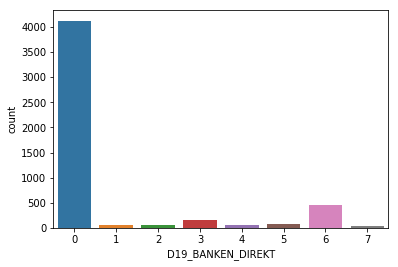

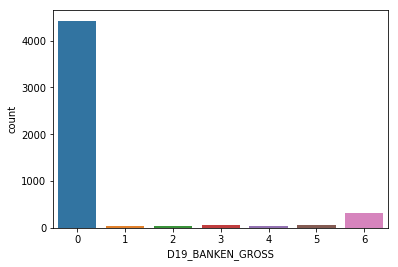

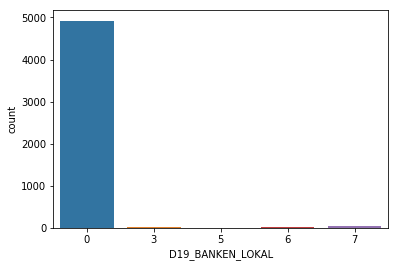

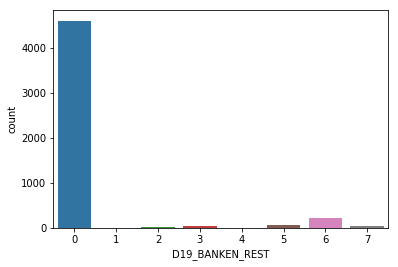

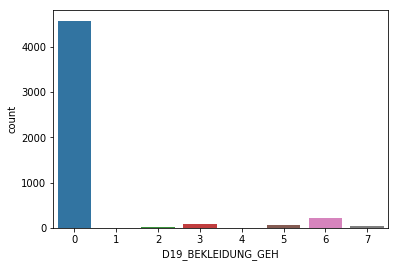

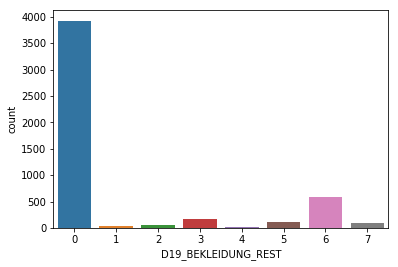

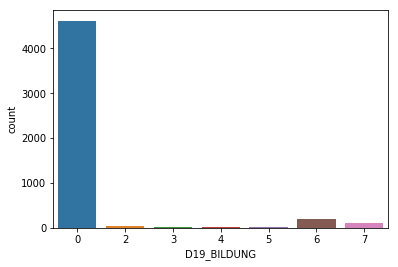

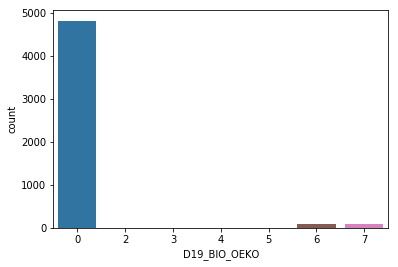

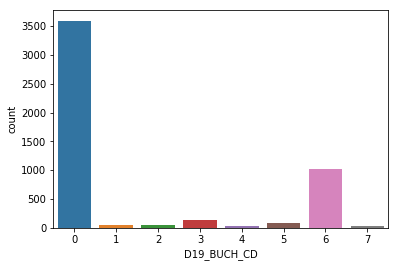

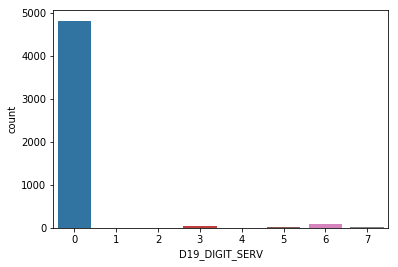

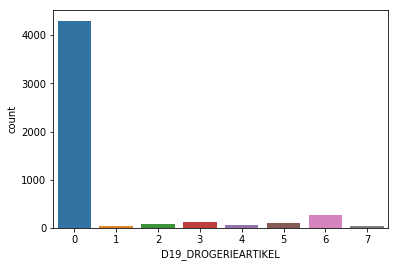

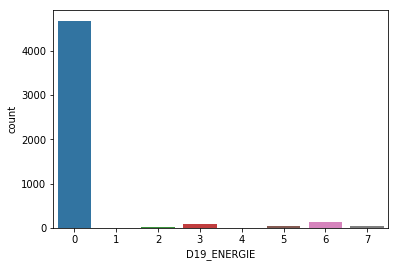

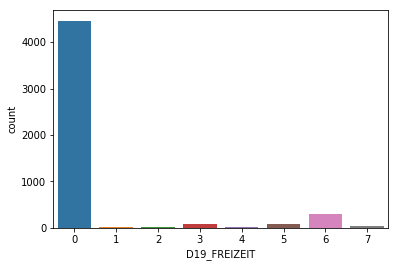

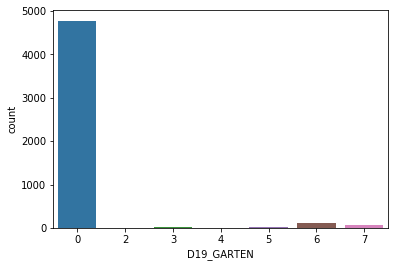

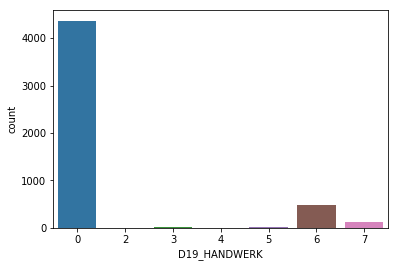

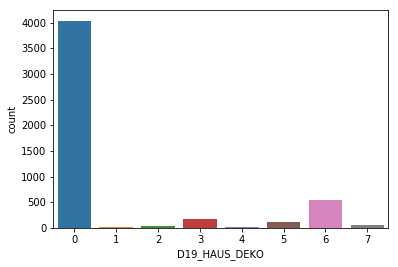

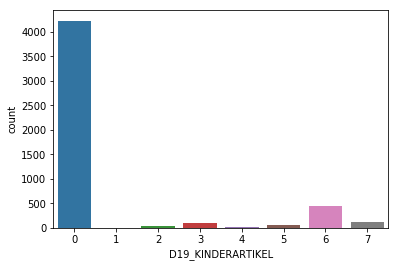

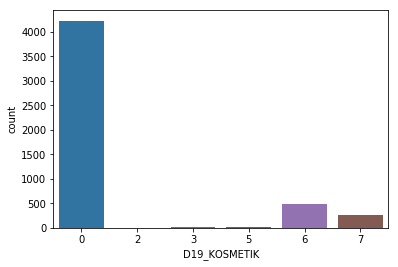

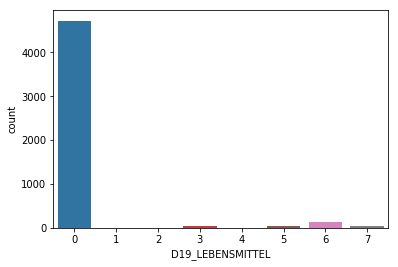

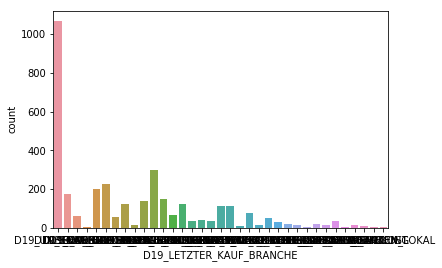

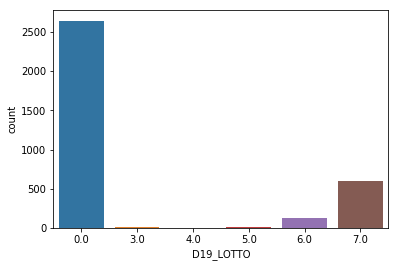

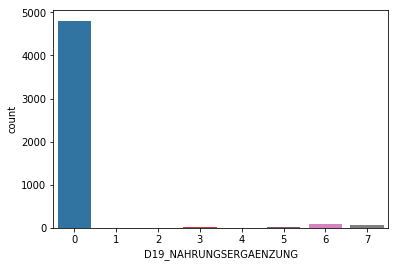

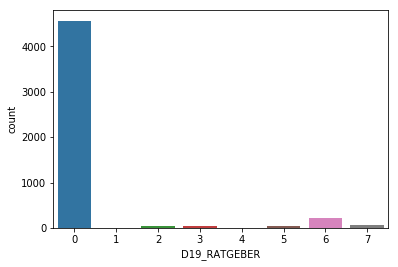

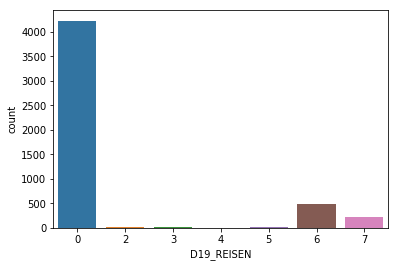

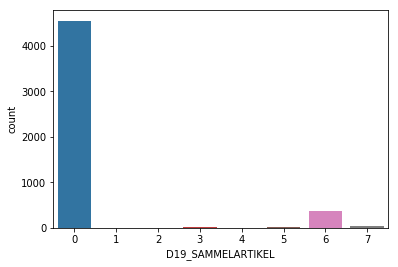

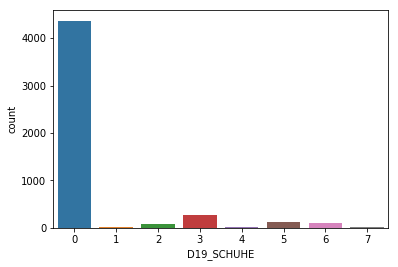

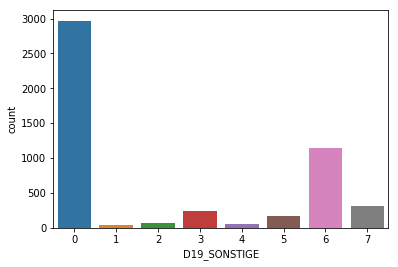

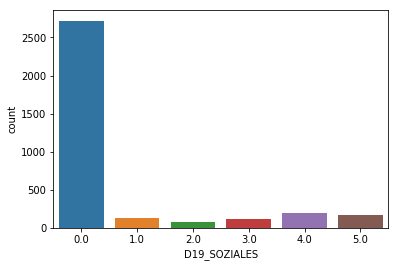

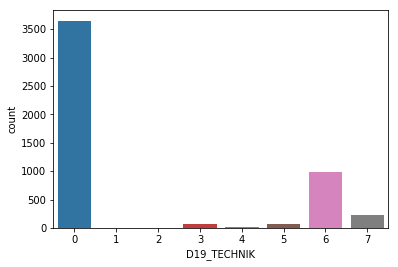

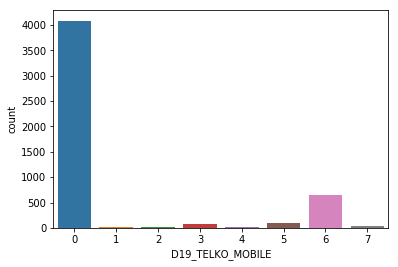

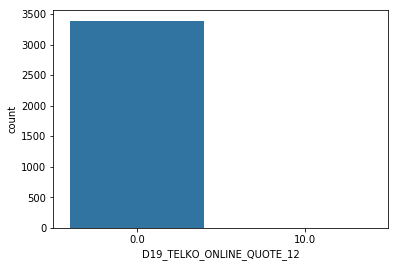

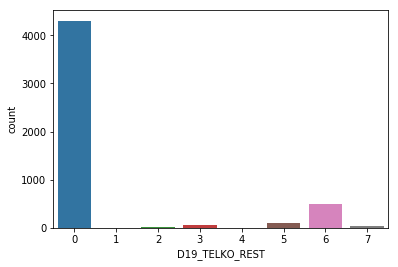

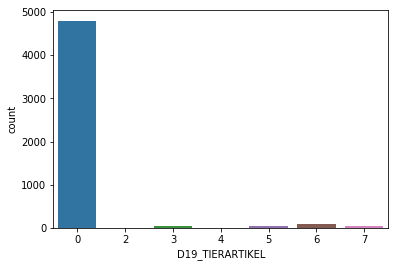

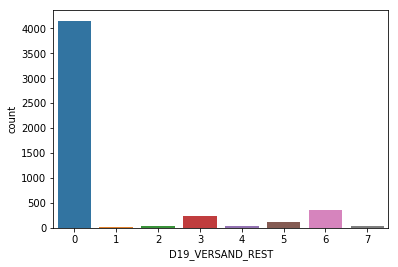

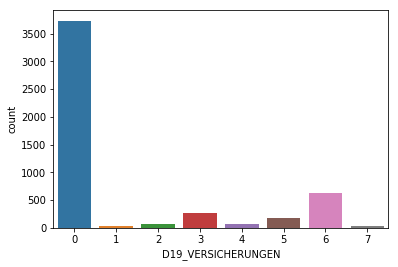

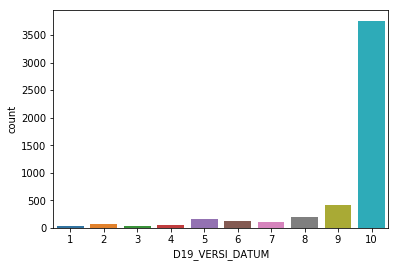

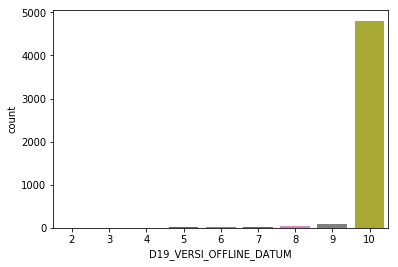

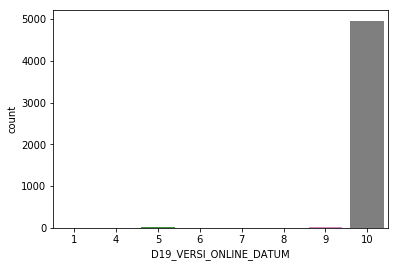

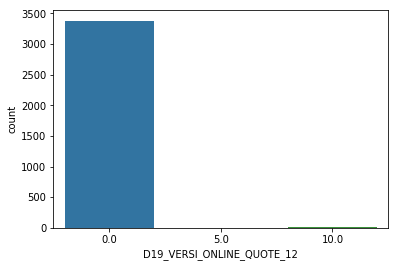

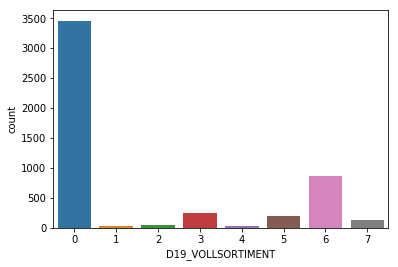

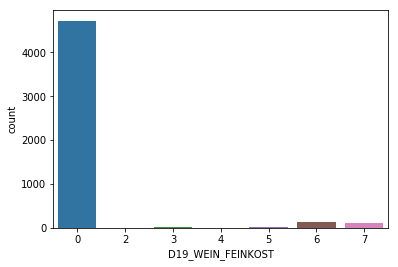

In [50]:
feat_ = []

d19_ = [feat for feat in feat_to_analyze if 'D19' in feat and 'TYP' not in feat]
print(d19_)

for feat in d19_:
    if feat not in df_features['Attribute'].values:
#         print("{:} contains {:.2f}% na's".format(feat, 100*azdias[feat].isna().mean()))
        fig, ax = plt.subplots()
        sns.countplot(azdias[feat])
        feat_.append(feat)

without much information available, i will assume all the above listed features are ordinal data

In [52]:
cat_features.extend(['D19_LETZTER_KAUF_BRANCHE'])  # last purchase sector? the informatoin doesn't seem to be so relavent

In [53]:
# azdias['D19_LETZTER_KAUF_BRANCHE'].unique()

#### KBA05

In [54]:
kba05_ = [feat for feat in feat_to_analyze if 'KBA05' in feat and 'TYP' not in feat]
print(kba05_)

[]


#### KBA13

In [55]:
kba13_ = [feat for feat in feat_to_analyze if 'KBA13' in feat and 'TYP' not in feat]
print(kba13_)

['KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210']


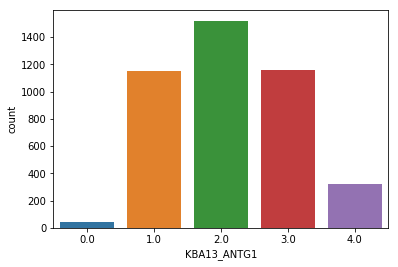

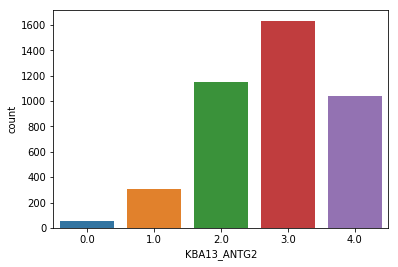

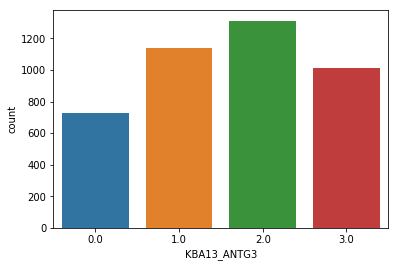

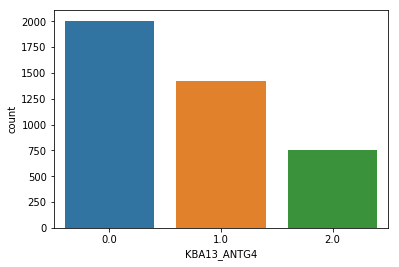

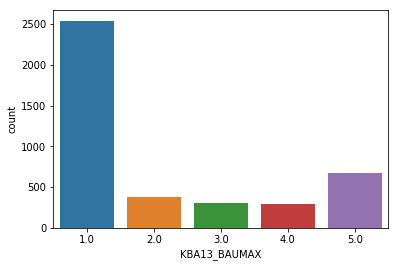

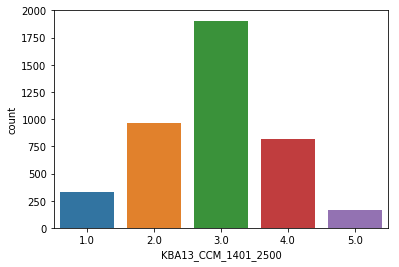

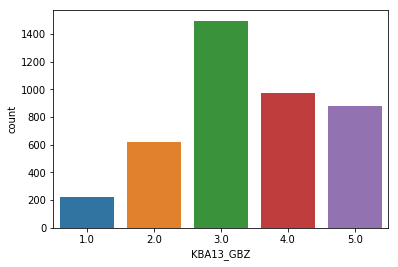

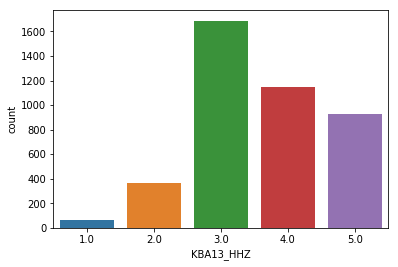

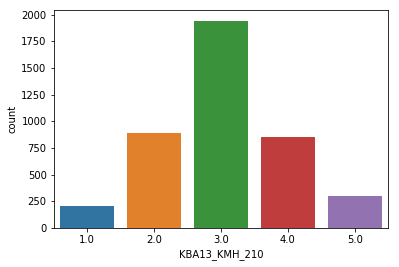

In [56]:
for feat in kba13_:
    if feat not in df_features['Attribute'].values:
#         print("{:} contains {:.2f}% na's".format(feat, 100*azdias[feat].isna().mean()))
        fig, ax = plt.subplots()
        sns.countplot(azdias[feat])
        feat_.append(feat)

KBA13 data is mostly ordinal, i will assume it to be ordinal

#### LP

In [57]:
lp_ = [feat for feat in feat_to_analyze if 'LP' in feat and 'TYP' not in feat]
print(lp_)

[]


#### FINANZ

In [58]:
finanz_ = [feat for feat in feat_to_analyze if 'FINANZ' in feat and 'TYP' not in feat]
print(finanz_)

[]


#### ANZ

In [59]:
anz_ = [feat for feat in feat_to_analyze if 'ANZ' in feat and 'TYP' not in feat]
print(anz_)

['ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'VK_DISTANZ']


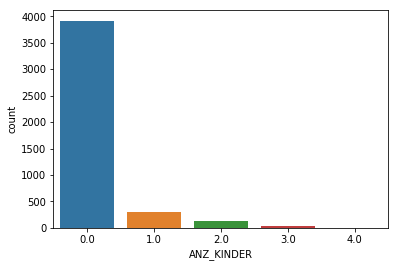

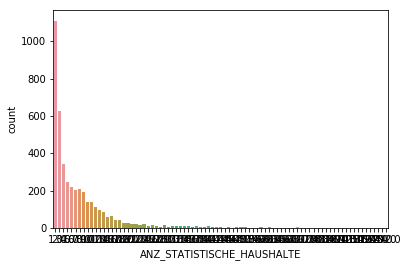

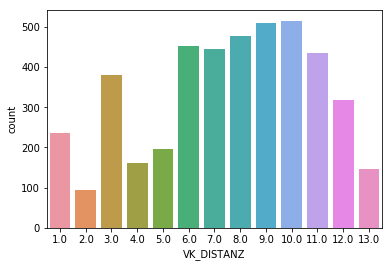

In [60]:
for feat in anz_:
    if feat not in df_features['Attribute'].values:
#         print("{:} contains {:.2f}% na's".format(feat, 100*azdias[feat].isna().mean()))
        fig, ax = plt.subplots()
        sns.countplot(azdias[feat])
        feat_.append(feat)

In [61]:
num_features.extend(anz_)

#### CAMEO 

In [62]:
cameo_ = [feat for feat in feat_to_analyze if 'CAMEO' in feat and 'TYP' not in feat]
print(cameo_)

['CAMEO_INTL_2015']


In [63]:
cat_features.extend(cameo_)

#### GEBAEUDETYP

In [64]:
GEBAEUDETYP_ = [feat for feat in feat_to_analyze if 'GEBAEUDETYP' in feat and 'TYP' not in feat]
print(GEBAEUDETYP_)

[]


####  analyze unexplored features

In [65]:
remaining_feats = feat_to_analyze

In [66]:
for f in [d19_, kba05_, kba13_, lp_, finanz_, anz_, cameo_, GEBAEUDETYP_, typ_]:
#     print(f)
    remaining_feats = list (set(remaining_feats) - set(f))
    
print( 'there are in total {:} features remain to be examined manually/individually'.format(len(remaining_feats)))

there are in total 52 features remain to be examined manually/individually


In [67]:
print(remaining_feats)

['ALTER_KIND3', 'RT_UEBERGROESSE', 'BALLRAUM', 'ALTER_KIND2', 'RT_SCHNAEPPCHEN', 'RELAT_AB', 'W_KEIT_KIND_HH', 'AKT_DAT_KL', 'OST_WEST_KZ', 'RT_KEIN_ANREIZ', 'UMFELD_ALT', 'MIN_GEBAEUDEJAHR', 'VK_DHT4A', 'INNENSTADT', 'MOBI_REGIO', 'GEBURTSJAHR', 'HH_EINKOMMEN_SCORE', 'ALTERSKATEGORIE_FEIN', 'VHA', 'VERDICHTUNGSRAUM', 'WOHNDAUER_2008', 'VK_ZG11', 'VHN', 'EXTSEL992', 'HH_DELTA_FLAG', 'ALTER_HH', 'SOHO_KZ', 'TITEL_KZ', 'ORTSGR_KLS9', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'WOHNLAGE', 'CJT_KATALOGNUTZER', 'ANREDE_KZ', 'MOBI_RASTER', 'ALTERSKATEGORIE_GROB', 'UNGLEICHENN_FLAG', 'KOMBIALTER', 'DSL_FLAG', 'ALTER_KIND1', 'ONLINE_AFFINITAET', 'KONSUMNAEHE', 'EWDICHTE', 'UMFELD_JUNG', 'NATIONALITAET_KZ', 'KKK', 'PRAEGENDE_JUGENDJAHRE', 'FIRMENDICHTE', 'KONSUMZELLE', 'GREEN_AVANTGARDE', 'ALTER_KIND4', 'ARBEIT']


In [68]:
for feat in remaining_feats:
    if feat in df_features['Attribute'].values:
        print(feat)
        display(df_features.loc[df_features.Attribute == feat])

BALLRAUM


,Attribute,Value,Meaning,attribute_prefix
40,BALLRAUM,-1,unknown,BALLRAUM
41,BALLRAUM,1,till 10 km,BALLRAUM
42,BALLRAUM,2,10 - 20 km,BALLRAUM
43,BALLRAUM,3,20 - 30 km,BALLRAUM
44,BALLRAUM,4,30 - 40 km,BALLRAUM
45,BALLRAUM,5,40 - 50 km,BALLRAUM
46,BALLRAUM,6,50-100 km,BALLRAUM
47,BALLRAUM,7,more than 100 km,BALLRAUM


RELAT_AB


,Attribute,Value,Meaning,attribute_prefix
2078,RELAT_AB,1,very low,RELAT
2079,RELAT_AB,2,low,RELAT
2080,RELAT_AB,3,average,RELAT
2081,RELAT_AB,4,high,RELAT
2082,RELAT_AB,5,very high,RELAT
2083,RELAT_AB,"-1, 9",unknown,RELAT


W_KEIT_KIND_HH


,Attribute,Value,Meaning,attribute_prefix
2244,W_KEIT_KIND_HH,"-1, 0",unknown,W
2245,W_KEIT_KIND_HH,1,most likely,W
2246,W_KEIT_KIND_HH,2,very likely,W
2247,W_KEIT_KIND_HH,3,likely,W
2248,W_KEIT_KIND_HH,4,average,W
2249,W_KEIT_KIND_HH,5,unlikely,W
2250,W_KEIT_KIND_HH,6,very unlikely,W


OST_WEST_KZ


,Attribute,Value,Meaning,attribute_prefix
2013,OST_WEST_KZ,-1,unknown,OST
2014,OST_WEST_KZ,O,East (GDR),OST
2015,OST_WEST_KZ,W,West (FRG),OST


MIN_GEBAEUDEJAHR


,Attribute,Value,Meaning,attribute_prefix
1986,MIN_GEBAEUDEJAHR,…,numeric value,MIN


INNENSTADT


,Attribute,Value,Meaning,attribute_prefix
756,INNENSTADT,-1,unknown,INNENSTADT
757,INNENSTADT,1,city centre,INNENSTADT
758,INNENSTADT,2,distance to the city centre 3 km,INNENSTADT
759,INNENSTADT,3,distance to the city centre 3-5 km,INNENSTADT
760,INNENSTADT,4,distance to the city centre 5-10 km,INNENSTADT
761,INNENSTADT,5,distance to the city centre 10-20 km,INNENSTADT
762,INNENSTADT,6,distance to the city centre 20-30 km,INNENSTADT
763,INNENSTADT,7,distance to the city centre 30-40 km,INNENSTADT
764,INNENSTADT,8,distance to the city centre > 40 km,INNENSTADT


MOBI_REGIO


,Attribute,Value,Meaning,attribute_prefix
1987,MOBI_REGIO,1,very high mobility,MOBI
1988,MOBI_REGIO,2,high mobility,MOBI
1989,MOBI_REGIO,3,middle mobility,MOBI
1990,MOBI_REGIO,4,low mobility,MOBI
1991,MOBI_REGIO,5,very low mobility,MOBI
1992,MOBI_REGIO,6,none,MOBI


GEBURTSJAHR


,Attribute,Value,Meaning,attribute_prefix
711,GEBURTSJAHR,…,numeric value,GEBURTSJAHR


HH_EINKOMMEN_SCORE


,Attribute,Value,Meaning,attribute_prefix
749,HH_EINKOMMEN_SCORE,"-1, 0",unknown,HH
750,HH_EINKOMMEN_SCORE,1,highest income,HH
751,HH_EINKOMMEN_SCORE,2,very high income,HH
752,HH_EINKOMMEN_SCORE,3,high income,HH
753,HH_EINKOMMEN_SCORE,4,average income,HH
754,HH_EINKOMMEN_SCORE,5,lower income,HH
755,HH_EINKOMMEN_SCORE,6,very low income,HH


WOHNDAUER_2008


,Attribute,Value,Meaning,attribute_prefix
2219,WOHNDAUER_2008,"-1, 0",unknown,WOHNDAUER
2220,WOHNDAUER_2008,1,length of residence below 1 year,WOHNDAUER
2221,WOHNDAUER_2008,2,length of residence 1-2 years,WOHNDAUER
2222,WOHNDAUER_2008,3,length of residence 2-3 years,WOHNDAUER
2223,WOHNDAUER_2008,4,length of residence 3-4 years,WOHNDAUER
2224,WOHNDAUER_2008,5,length of residence 4-5 years,WOHNDAUER
2225,WOHNDAUER_2008,6,length of residence 5-6 years,WOHNDAUER
2226,WOHNDAUER_2008,7,length of residence 6-7 years,WOHNDAUER
2227,WOHNDAUER_2008,8,length of residence 7-10 years,WOHNDAUER
2228,WOHNDAUER_2008,9,length of residence more than 10 years,WOHNDAUER


ALTER_HH


,Attribute,Value,Meaning,attribute_prefix
11,ALTER_HH,0,unknown / no main age detectable,ALTER
12,ALTER_HH,1,01.01.1895 bis 31.12.1899,ALTER
13,ALTER_HH,2,01.01.1900 bis 31.12.1904,ALTER
14,ALTER_HH,3,01.01.1905 bis 31.12.1909,ALTER
15,ALTER_HH,4,01.01.1910 bis 31.12.1914,ALTER
16,ALTER_HH,5,01.01.1915 bis 31.12.1919,ALTER
17,ALTER_HH,6,01.01.1920 bis 31.12.1924,ALTER
18,ALTER_HH,7,01.01.1925 bis 31.12.1929,ALTER
19,ALTER_HH,8,01.01.1930 bis 31.12.1934,ALTER
20,ALTER_HH,9,01.01.1935 bis 31.12.1939,ALTER


TITEL_KZ


,Attribute,Value,Meaning,attribute_prefix
2210,TITEL_KZ,"-1, 0",unknown,TITEL
2211,TITEL_KZ,1,Dr.,TITEL
2212,TITEL_KZ,2,Dr. Dr.,TITEL
2213,TITEL_KZ,3,Prof.,TITEL
2214,TITEL_KZ,4,Prof. Dr.,TITEL
2215,TITEL_KZ,5,other,TITEL


ORTSGR_KLS9


,Attribute,Value,Meaning,attribute_prefix
2003,ORTSGR_KLS9,-1,unknown,ORTSGR
2004,ORTSGR_KLS9,1,<= 2.000 inhabitants,ORTSGR
2005,ORTSGR_KLS9,2,2.001 to 5.000 inhabitants,ORTSGR
2006,ORTSGR_KLS9,3,5.001 to 10.000 inhabitants,ORTSGR
2007,ORTSGR_KLS9,4,10.001 to 20.000 inhabitants,ORTSGR
2008,ORTSGR_KLS9,5,20.001 to 50.000 inhabitants,ORTSGR
2009,ORTSGR_KLS9,6,50.001 to 100.000 inhabitants,ORTSGR
2010,ORTSGR_KLS9,7,100.001 to 300.000 inhabitants,ORTSGR
2011,ORTSGR_KLS9,8,300.001 to 700.000 inhabitants,ORTSGR
2012,ORTSGR_KLS9,9,> 700.000 inhabitants,ORTSGR


WOHNLAGE


,Attribute,Value,Meaning,attribute_prefix
2229,WOHNLAGE,-1,unknown,WOHNLAGE
2230,WOHNLAGE,0,no score calculated,WOHNLAGE
2231,WOHNLAGE,1,very good neighbourhood,WOHNLAGE
2232,WOHNLAGE,2,good neighbourhood,WOHNLAGE
2233,WOHNLAGE,3,average neighbourhood,WOHNLAGE
2234,WOHNLAGE,4,poor neighbourhood,WOHNLAGE
2235,WOHNLAGE,5,very poor neighbourhood,WOHNLAGE
2236,WOHNLAGE,7,rural neighbourhood,WOHNLAGE
2237,WOHNLAGE,8,new building in rural neighbourhood,WOHNLAGE


ANREDE_KZ


,Attribute,Value,Meaning,attribute_prefix
33,ANREDE_KZ,"-1, 0",unknown,ANREDE
34,ANREDE_KZ,1,male,ANREDE
35,ANREDE_KZ,2,female,ANREDE


ALTERSKATEGORIE_GROB


,Attribute,Value,Meaning,attribute_prefix
5,ALTERSKATEGORIE_GROB,"-1, 0",unknown,ALTERSKATEGORIE
6,ALTERSKATEGORIE_GROB,1,< 30 years,ALTERSKATEGORIE
7,ALTERSKATEGORIE_GROB,2,30 - 45 years,ALTERSKATEGORIE
8,ALTERSKATEGORIE_GROB,3,46 - 60 years,ALTERSKATEGORIE
9,ALTERSKATEGORIE_GROB,4,> 60 years,ALTERSKATEGORIE
10,ALTERSKATEGORIE_GROB,9,uniformly distributed,ALTERSKATEGORIE


ONLINE_AFFINITAET


,Attribute,Value,Meaning,attribute_prefix
1997,ONLINE_AFFINITAET,0,none,ONLINE
1998,ONLINE_AFFINITAET,1,low,ONLINE
1999,ONLINE_AFFINITAET,2,middle,ONLINE
2000,ONLINE_AFFINITAET,3,high,ONLINE
2001,ONLINE_AFFINITAET,4,very high,ONLINE
2002,ONLINE_AFFINITAET,5,highest,ONLINE


KONSUMNAEHE


,Attribute,Value,Meaning,attribute_prefix
1885,KONSUMNAEHE,1,building is located in a 125 x 125m-grid cell ...,KONSUMNAEHE
1886,KONSUMNAEHE,2,"building is located in a 250 x 250m-grid cell,...",KONSUMNAEHE
1887,KONSUMNAEHE,3,"building is located in a 500 x 500m-grid cell,...",KONSUMNAEHE
1888,KONSUMNAEHE,4,"building is located in a 1 x 1km-grid cell, wh...",KONSUMNAEHE
1889,KONSUMNAEHE,5,"building is located in a 2 x 2km-grid cell, wh...",KONSUMNAEHE
1890,KONSUMNAEHE,6,"building is located in a 10 x 10km-grid cell, ...",KONSUMNAEHE
1891,KONSUMNAEHE,7,building is not located in a 10 x 10km-range t...,KONSUMNAEHE


EWDICHTE


,Attribute,Value,Meaning,attribute_prefix
647,EWDICHTE,-1,unknown,EWDICHTE
648,EWDICHTE,1,less than 34 HH/km²,EWDICHTE
649,EWDICHTE,2,34 - 89 HH/km²,EWDICHTE
650,EWDICHTE,3,90 - 149 HH/km²,EWDICHTE
651,EWDICHTE,4,150 - 319 HH/km²,EWDICHTE
652,EWDICHTE,5,320 - 999 HH/km²,EWDICHTE
653,EWDICHTE,6,more than 999 HH/²,EWDICHTE


NATIONALITAET_KZ


,Attribute,Value,Meaning,attribute_prefix
1993,NATIONALITAET_KZ,"-1, 0",unknown,NATIONALITAET
1994,NATIONALITAET_KZ,1,sounding german,NATIONALITAET
1995,NATIONALITAET_KZ,2,sounding foreign,NATIONALITAET
1996,NATIONALITAET_KZ,3,assimilated names,NATIONALITAET


KKK


,Attribute,Value,Meaning,attribute_prefix
1880,KKK,"-1, 0",unknown,KKK
1881,KKK,1,very high,KKK
1882,KKK,2,high,KKK
1883,KKK,3,average,KKK
1884,KKK,4,low,KKK


PRAEGENDE_JUGENDJAHRE


,Attribute,Value,Meaning,attribute_prefix
2054,PRAEGENDE_JUGENDJAHRE,"-1, 0",unknown,PRAEGENDE
2055,PRAEGENDE_JUGENDJAHRE,1,"40ies - war years (Mainstream, O+W)",PRAEGENDE
2056,PRAEGENDE_JUGENDJAHRE,2,"40ies - reconstruction years (Avantgarde, O+W)",PRAEGENDE
2057,PRAEGENDE_JUGENDJAHRE,3,"50ies - economic miracle (Mainstream, O+W)",PRAEGENDE
2058,PRAEGENDE_JUGENDJAHRE,4,50ies - milk bar / Individualisation (Avantgar...,PRAEGENDE
2059,PRAEGENDE_JUGENDJAHRE,5,"60ies - economic miracle (Mainstream, O+W)",PRAEGENDE
2060,PRAEGENDE_JUGENDJAHRE,6,60ies - generation 68 / student protestors (Av...,PRAEGENDE
2061,PRAEGENDE_JUGENDJAHRE,7,60ies - opponents to the building of the Wall ...,PRAEGENDE
2062,PRAEGENDE_JUGENDJAHRE,8,"70ies - family orientation (Mainstream, O+W)",PRAEGENDE
2063,PRAEGENDE_JUGENDJAHRE,9,"70ies - peace movement (Avantgarde, O+W)",PRAEGENDE


GREEN_AVANTGARDE


,Attribute,Value,Meaning,attribute_prefix
732,GREEN_AVANTGARDE,0,doesn't belong to the green avantgarde,GREEN
733,GREEN_AVANTGARDE,1,belongs to the green avantgarde,GREEN


In [69]:
num_features.extend(['MIN_GEBAEUDEJAHR', 'GEBURTSJAHR', ])
cat_features.extend(['GREEN_AVANTGARDE', 'OST_WEST_KZ',
                     'TITEL_KZ', 'ALTERSKATEGORIE_GROB', 'NATIONALITAET_KZ', 
                     'ANREDE_KZ',  'PRAEGENDE_JUGENDJAHRE', "WOHNLAGE", "ALTER", "ALTER_HH", 
                     'KONSUMNAEHE', 'ORTSGR_KLS9', 'PRAEGENDE_JUGENDJAHRE', 
                    ])

In [70]:
# remaining_feats

ALTER_KIND3 contains 99.26% na's
RT_UEBERGROESSE contains 8.96% na's
ALTER_KIND2 contains 96.78% na's
RT_SCHNAEPPCHEN contains 0.56% na's
AKT_DAT_KL contains 12.40% na's
RT_KEIN_ANREIZ contains 0.56% na's
UMFELD_ALT contains 15.34% na's
VK_DHT4A contains 12.66% na's
ALTERSKATEGORIE_FEIN contains 33.60% na's
VHA contains 12.40% na's
VERDICHTUNGSRAUM contains 15.18% na's
VK_ZG11 contains 12.66% na's
VHN contains 17.98% na's
EXTSEL992 contains 75.08% na's
HH_DELTA_FLAG contains 16.24% na's
SOHO_KZ contains 12.40% na's
EINGEFUEGT_AM contains 14.66% na's
EINGEZOGENAM_HH_JAHR contains 12.40% na's
CJT_KATALOGNUTZER contains 0.56% na's
MOBI_RASTER contains 14.66% na's
UNGLEICHENN_FLAG contains 12.40% na's


C:\ProgramData\Anaconda3\Lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KOMBIALTER contains 0.00% na's
DSL_FLAG contains 14.66% na's
ALTER_KIND1 contains 91.36% na's
UMFELD_JUNG contains 15.34% na's
FIRMENDICHTE contains 14.66% na's
KONSUMZELLE contains 14.66% na's
ALTER_KIND4 contains 99.98% na's
ARBEIT contains 15.16% na's


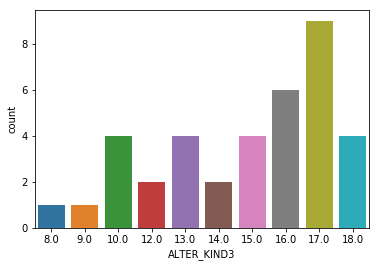

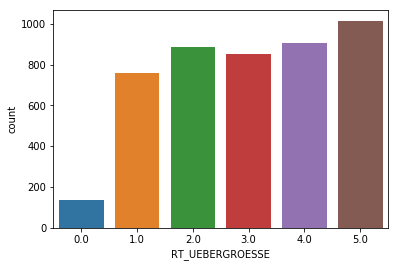

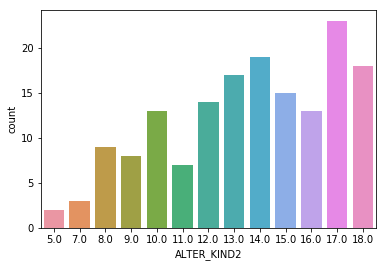

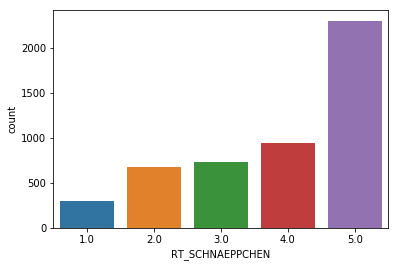

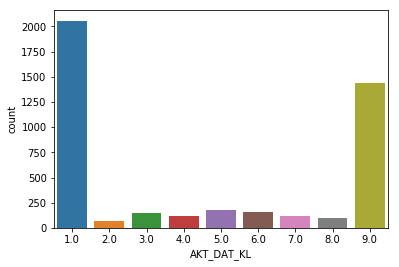

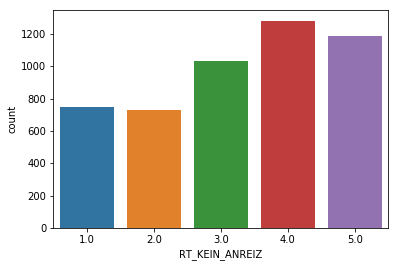

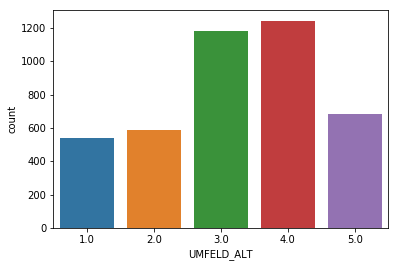

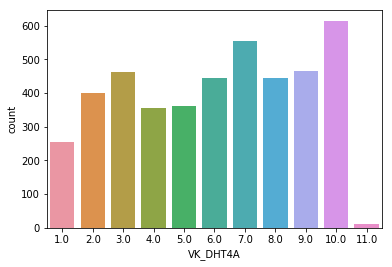

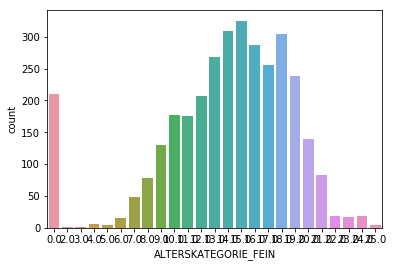

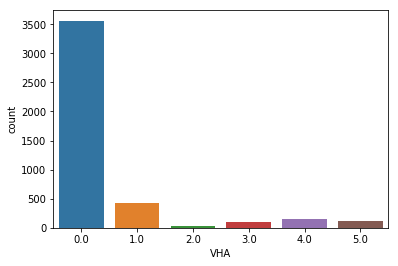

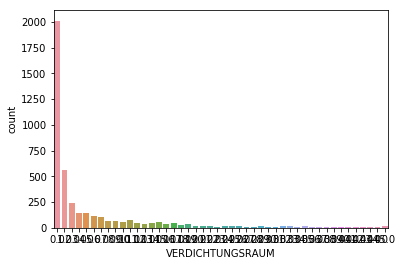

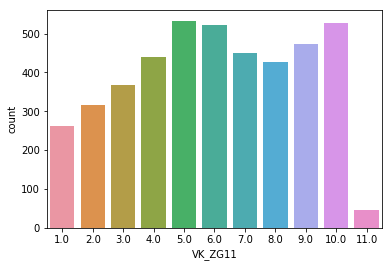

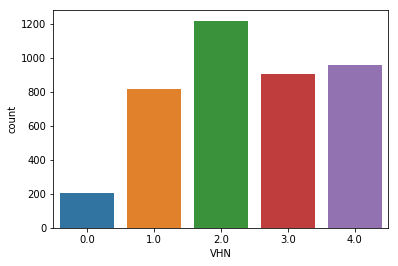

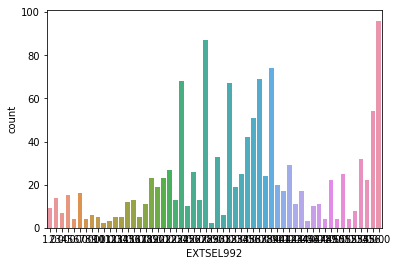

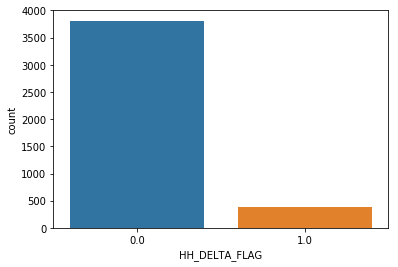

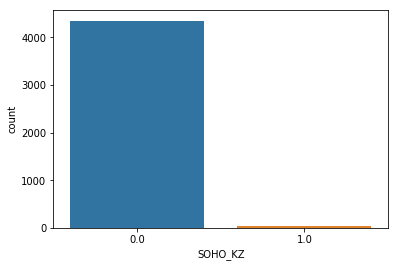

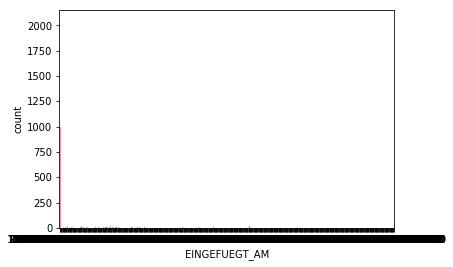

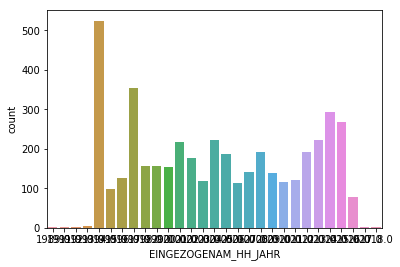

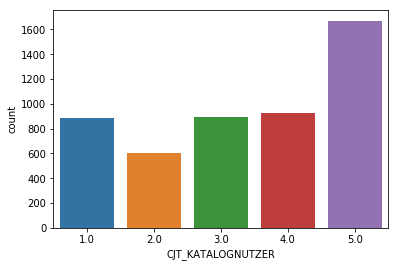

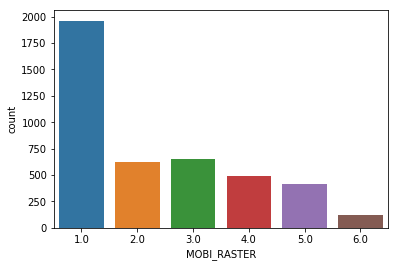

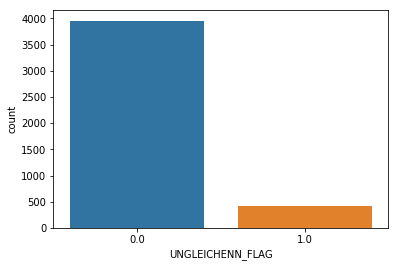

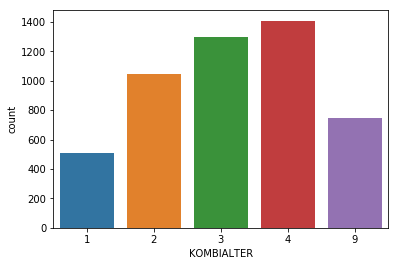

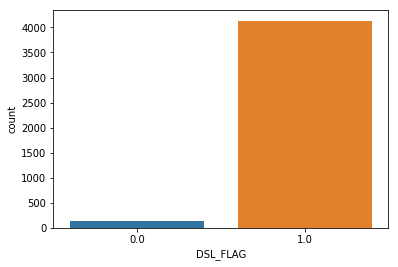

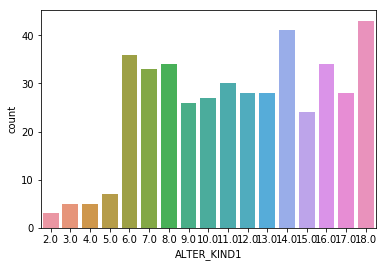

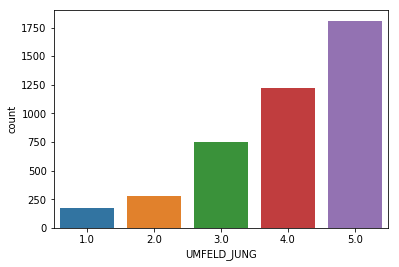

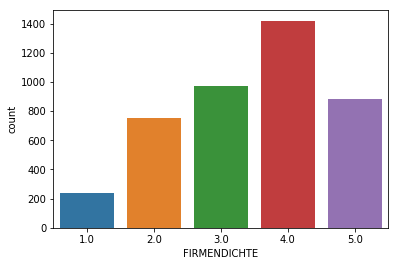

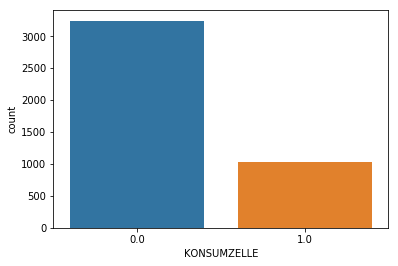

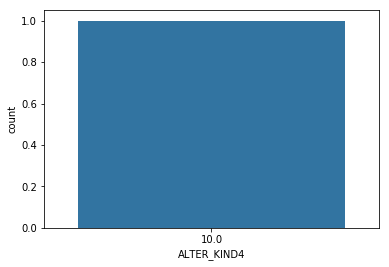

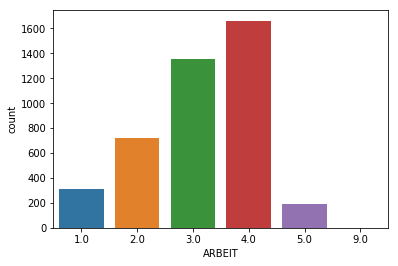

In [71]:
feat_ = []

for feat in remaining_feats:
    if feat not in df_features['Attribute'].values:
        print("{:} contains {:.2f}% na's".format(feat, 100*azdias[feat].isna().mean()))
        
        fig, ax = plt.subplots()
        sns.countplot(azdias[feat])
        feat_.append(feat)

In [72]:
# I will drop theses columns either because they do not provides too much info (contains too many cats, or too many nan's)
# to_drop = ['ALTER_KIND3', 'AKT_DAT_KL', 'ALTER_KIND1', 'VHA', 
#            'ALTER_KIND4','VERDICHTUNGSRAUM', 'EXTSEL992','ALTER_KIND2'] 

num_features.extend(['EINGEFUEGT_AM', "ALTER_KIND3 ",
                     'EINGEZOGENAM_HH_JAHR',
                    'EXTSEL992',
                    'VERDICHTUNGSRAUM',
                    'ALTER_KIND2',
                    'ALTER_KIND1',
                    'ALTER_KIND4'])
cat_features.extend(list(set(feat_) - set(['EINGEFUEGT_AM', "ALTER_KIND3 ",
                     'EINGEZOGENAM_HH_JAHR',
                    'EXTSEL992',
                    'VERDICHTUNGSRAUM',
                    'ALTER_KIND2',
                    'ALTER_KIND1',
                    'ALTER_KIND4'])))


### update feature summary table

#### update using data type

In [73]:
for feat in cat_features:
    df_feat_summary.loc[df_feat_summary['Attribute'] == feat, 'type'] = 'categorical'

In [74]:
for feat in num_features:
    df_feat_summary.loc[df_feat_summary['Attribute'] == feat, 'type'] = 'numerical'

In [75]:
df_feat_summary['type'].value_counts()

ordinal        276
categorical     73
numerical       16
Name: type, dtype: int64

###  update feature summary table
#### include missing values encoding 

It is noticed from the analysis the some of values presents unknowns or missing data, Those valuse are normally described as 'no transactions', 'unknown', 'no transaction' in the informatoin file ('DIAS Attributes - Values 2017.xlsx'). I will serach for these key words in the df_features to get to know the values assigned to unknowns or missing values.

In [76]:
df_features_nan = unknown_encoding(
    df_features, search_for='|'.join(['no transactions', 'unknown', 'no transaction']))

In [77]:
df_features_nan['Meaning'].unique()

array(['unknown', 'unknown / no main age detectable',
       'no transactions known', 'no transaction known'], dtype=object)

In [78]:
df_feat_summary = df_feat_summary.merge( df_features_nan,left_on='Attribute', right_on='Attribute', how = 'left')
df_feat_summary.loc[df_feat_summary.type == 'numerical', "Value"] = [0]  # Numerical vlaues normally start from 1, if there is a zero, it means hte 

In [79]:
df_feat_summary

,Attribute,type,Value,Meaning,attribute_prefix
0,KBA13_KMH_140_210,ordinal,[-1],unknown,KBA13
1,CJT_GESAMTTYP,categorical,[0],unknown,CJT
2,FINANZ_VORSORGER,ordinal,[-1],unknown,FINANZ
3,D19_GARTEN,ordinal,NaN,NaN,NaN
4,KBA05_CCM2,ordinal,"[-1, 9]",unknown,KBA05
...,...,...,...,...,...
360,D19_ENERGIE,ordinal,NaN,NaN,NaN
361,KBA13_FORD,ordinal,[-1],unknown,KBA13
362,VK_DISTANZ,numerical,0,NaN,NaN
363,CJT_TYP_3,categorical,NaN,NaN,NaN


In [80]:
df_feat_summary.drop(['Meaning', 'attribute_prefix'], axis=1, inplace=True)

In [83]:
#  ['ANREDE_KZ','ALTERSKATEGORIE_GROB']

In [81]:
df_feat_summary.to_csv('feat_summary.csv')
df_feat_summary.to_pickle('feat_summary.pkl')

In [82]:
# cat_features